# Investments Project (Spring 2024)

**Authors:**
- Marc-Antoine Allard
- Adam Zinebi
- Paul Teiletche
- ...

**DUE Date: June 21 at 23:59**

---
# Imports

In [1]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import datetime
#import wrds
import source.utils
import seaborn as sns

---
# The Data

*Download monthly stock returns from CRSP from January 1, 1964, to December 31, 2023, for all common stocks traded on the NYSE and AMEX. Also, download the value-weighted CRSP market return and 1-month T-bill returns as a risk-free rate. Many of the relevant SQL requests or Python commands are found in the previous exercises covered earlier during the semester.*

In [ ]:
data = pd.read_parquet('/content/drive/MyDrive/inv/investments_project/data/stock_data.parquet')

---
# Betting against Beta strategy (BaB)

*a) Compute the time-varying market βt,n for each stock by running monthly rolling 5-
year regressions of stock-specific excess returns on the excess market return. Require
at least 36 months of observations for each stock. Winsorize the beta at 5 and 95 %.*

In [ ]:
import pandas as pd
import statsmodels.api as sm
from tqdm import tqdm
data = data.dropna(subset=['mcap_l', 'Rn_e', 'Rm_e']).copy()

data['N'] = data.groupby(['permno'])['date'].transform('count')
data = data[data['N'] > 60].copy()
tqdm.pandas()

# 2. Function to calculate rolling beta using OLS regression
def calculate_rolling_beta(group, window=60, min_periods=36):
    group = group.sort_values('date')
    betas = pd.Series(index=group.index, dtype=float)
    for start in (range(len(group) - min_periods + 1)):
        end = start + window
        if end > len(group):
            end = len(group)
        subset = group.iloc[start:end]
        if len(subset) >= min_periods:
            X = sm.add_constant(subset['Rm_e'])
            y = subset['Rn_e']
            model = sm.OLS(y, X).fit()
            betas.iloc[end-1] = model.params['Rm_e']
    return betas

data['beta'] = data.groupby('permno').progress_apply(calculate_rolling_beta).reset_index(level=0, drop=True)

beta_5th = data['beta'].quantile(0.05)
beta_95th = data['beta'].quantile(0.95)
data['beta'] = data['beta'].clip(lower=beta_5th, upper=beta_95th)

data = data.drop(columns=['N'])


100%|██████████| 5922/5922 [45:39<00:00,  2.16it/s]


In [ ]:
data.to_parquet('slow_part.parquet')


In [2]:
import pandas as pd
data = pd.read_parquet('data/slow_part.parquet')

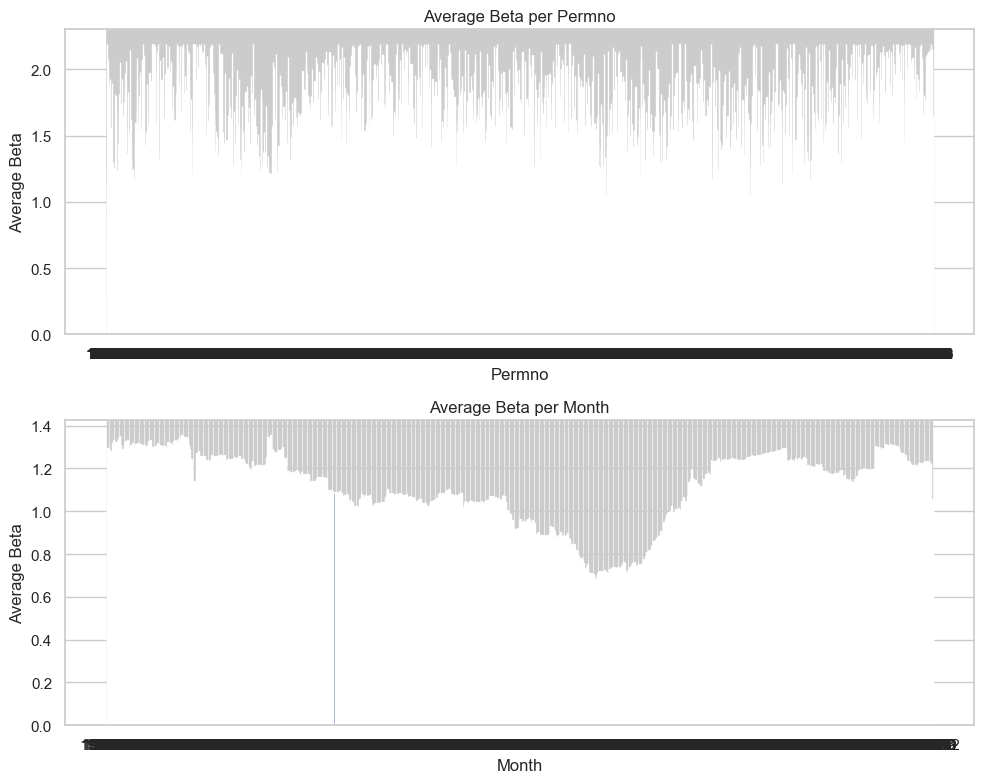

In [34]:
df = data
average_beta_permno = df.groupby('permno')['beta'].mean()

df['month'] = df['date'].dt.to_period('M')
average_beta_month = df.groupby('month')['beta'].mean()
average_beta_month_sorted = average_beta_month.sort_index()

fig, axs = plt.subplots(2, 1, figsize=(10, 8))

axs[0].bar(average_beta_permno.index.astype(str), average_beta_permno)
axs[0].set_title('Average Beta per Permno')
axs[0].set_xlabel('Permno')
axs[0].set_ylabel('Average Beta')

axs[1].bar(average_beta_month_sorted.index.astype(str), average_beta_month_sorted)
axs[1].set_title('Average Beta per Month')
axs[1].set_xlabel('Month')
axs[1].set_ylabel('Average Beta')

plt.tight_layout()
plt.show()


*b) At every month t, sort all stocks into deciles based on their beta (estimated using the most recent rolling window). Then compute monthly returns for 10 decile portfolios that equal weight all stocks in each decile. Plot the average annualized portfolio mean, standard deviation, and Sharpe ratios across the 10 deciles in three bar plots. Repeat for value-weighted decile portfolios. Summarize our findings. Is the evidence consistent with the CAPM?*

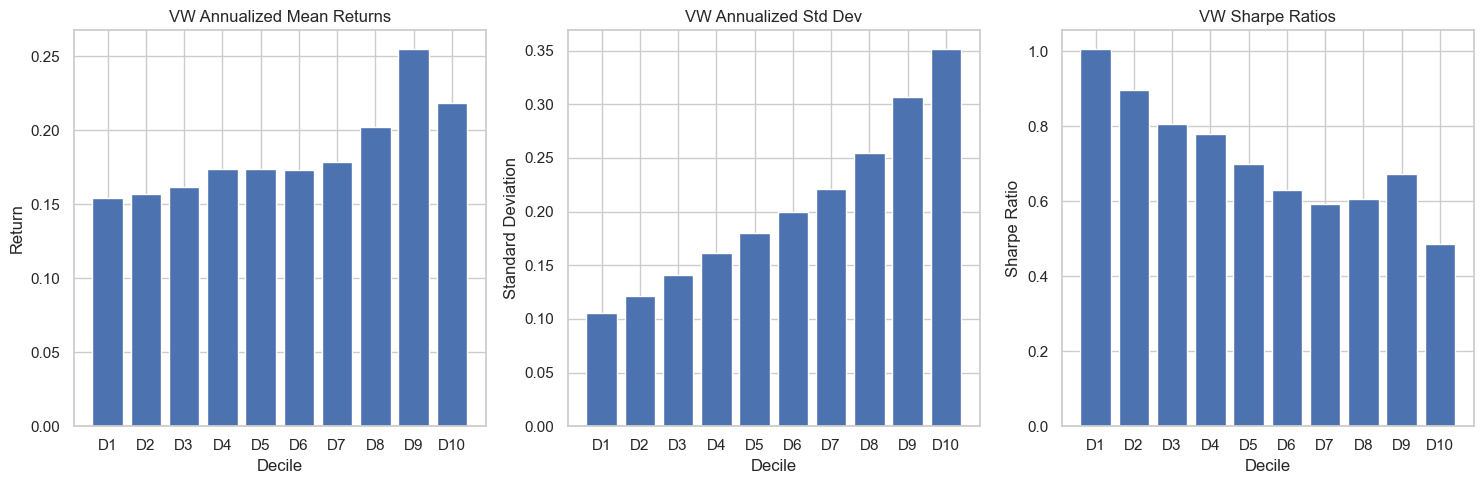

<BarContainer object of 10 artists>

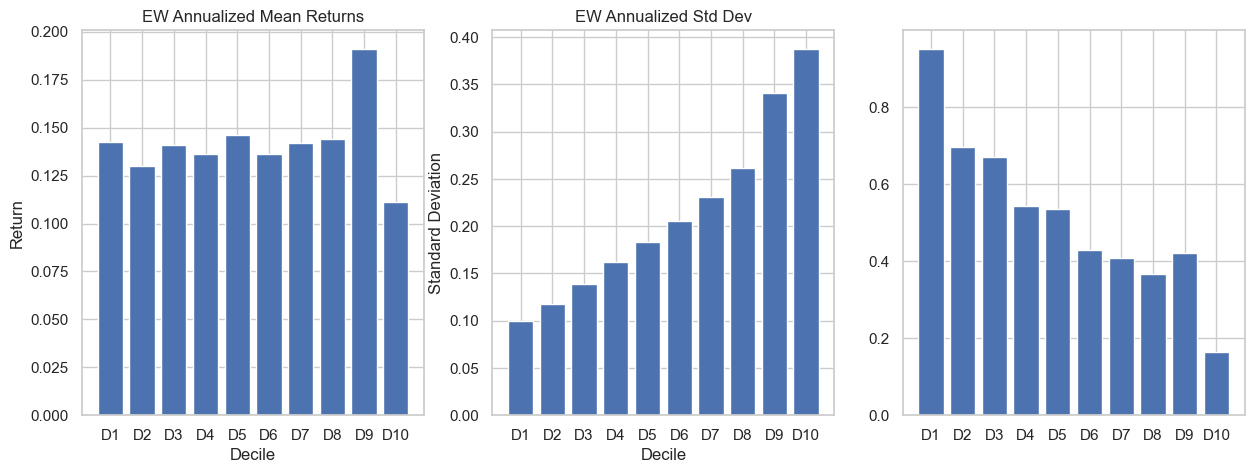

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def annualize_return(monthly_return):
    return ((1 + monthly_return)**12 - 1)

def sharpe_ratio(mean_return, std_dev, risk_free_rate):
    return (mean_return - risk_free_rate) / std_dev

data = data.dropna(subset=['beta']).copy()
data['beta_Q'] = data.groupby('date')['beta'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))

data['vw_Q'] = data['mcap'] / data.groupby(['date', 'beta_Q'])['mcap'].transform('sum')

data['beta_ret_vw'] = data['vw_Q'] * data['Rn']
ret_vw = data.groupby(['date', 'beta_Q'])['beta_ret_vw'].sum().reset_index()
vw_ret_mean = ret_vw.groupby('beta_Q')['beta_ret_vw'].mean()
vw_ret_std = ret_vw.groupby('beta_Q')['beta_ret_vw'].std()

ret_ew = data.groupby(['date', 'beta_Q'])['Rn'].mean().reset_index()
ew_ret_mean = ret_ew.groupby('beta_Q')['Rn'].mean()
ew_ret_std = ret_ew.groupby('beta_Q')['Rn'].std()

vw_ret_mean_annual = annualize_return(vw_ret_mean)
ew_ret_mean_annual = annualize_return(ew_ret_mean)

vw_ret_std_annual = vw_ret_std * np.sqrt(12)
ew_ret_std_annual = ew_ret_std * np.sqrt(12)
risk_free_rate_annual = annualize_return(data['rf'].mean())

vw_sharpe_ratios = sharpe_ratio(vw_ret_mean_annual, vw_ret_std_annual,risk_free_rate_annual)
ew_sharpe_ratios = sharpe_ratio(ew_ret_mean_annual, ew_ret_std_annual,risk_free_rate_annual)

deciles = ['D' + str(x) for x in range(1, 11)]

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.bar(deciles, vw_ret_mean_annual)
plt.title('VW Annualized Mean Returns')
plt.xlabel('Decile')
plt.ylabel('Return')

plt.subplot(1, 3, 2)
plt.bar(deciles, vw_ret_std_annual)
plt.title('VW Annualized Std Dev')
plt.xlabel('Decile')
plt.ylabel('Standard Deviation')

plt.subplot(1, 3, 3)
plt.bar(deciles, vw_sharpe_ratios)
plt.title('VW Sharpe Ratios')
plt.xlabel('Decile')
plt.ylabel('Sharpe Ratio')

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.bar(deciles, ew_ret_mean_annual)
plt.title('EW Annualized Mean Returns')
plt.xlabel('Decile')
plt.ylabel('Return')

plt.subplot(1, 3, 2)
plt.bar(deciles, ew_ret_std_annual)
plt.title('EW Annualized Std Dev')
plt.xlabel('Decile')
plt.ylabel('Standard Deviation')

plt.subplot(1, 3, 3)
plt.bar(deciles, ew_sharpe_ratios)


*c)*

In [5]:
# Weights
data['z'] = data.groupby('date')['beta'].transform(lambda x: x.rank())
data['z_'] = data['z']-data.groupby('date')['z'].transform('mean')
data['k'] = np.abs(data['z_'])
data['k'] = 2/data.groupby('date')['k'].transform('sum')
data['w_H'] = data['k'] * data['z_'] * (data['z_']>0)
data['w_L'] = -data['k'] * data['z_'] * (data['z_']<0)




d)

In [21]:
# Weighted returns and beta
data['beta_H'] = data['w_H'] * data['beta']
data['beta_L'] = data['w_L'] * data['beta']
data['R_H'] = data['w_H'] * data['Rn']
data['R_L'] = data['w_L'] * data['Rn']
data['R_H_e'] = data['w_H'] * data['Rn_e']
data['R_L_e'] = data['w_L'] * data['Rn_e']
BAB = data.groupby('date')[['R_H','R_L','R_H_e','R_L_e','beta_H','beta_L']].sum().reset_index()
df_Rf = data[['rf','date','Rm']]
df_Rf['date'] = df['date'].dt.strftime('%Y-%m')

BAB['BAB2'] = BAB['R_L_e']/BAB['beta_L'] - BAB['R_H_e']/BAB['beta_H']
BAB_final = BAB.drop(columns=['R_H','R_L','R_H_e','R_L_e','beta_H','beta_L'])
BAB_final['date'] = BAB_final['date'].dt.strftime('%Y-%m')
BAB_final['BAB'] = BAB_final['BAB2']
BAB_final = BAB_final.merge(df_Rf, on='date', how='left')
BAB_final = BAB_final.drop(columns=['BAB2'])

/var/folders/1y/cd26kgpx7jd535tgk4gkf_3r0000gn/T/ipykernel_16461/622410024.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Rf['date'] = df['date'].dt.strftime('%Y-%m')


In [ ]:
BAB_final.to_parquet('BAB_final.parquet')


In [26]:



mean_bab = BAB_final['BAB'].mean()
std_bab = BAB_final['BAB'].std()
risk_free_rate = BAB_final['rf'].mean()
sharpe_ratio = (mean_bab - risk_free_rate) / std_bab

BAB_final['excess_BAB'] = BAB_final['BAB'] - BAB_final['rf']

BAB_final['excess_market'] = BAB_final['Rm'] - BAB_final['rf']

X = sm.add_constant(BAB_final['excess_market'])
y = BAB_final['excess_BAB']
capm_model = sm.OLS(y, X).fit()

capm_alpha = capm_model.params[0]

print(f"Mean BAB: {mean_bab}")
print(f"Standard Deviation BAB: {std_bab}")
print(f"Sharpe Ratio BAB: {sharpe_ratio}")
print(f"CAPM Alpha BAB: {capm_alpha}")


Mean BAB: 0.008404269819996759
Standard Deviation BAB: 0.038641974263009284
Sharpe Ratio BAB: 0.11604276624076162
CAPM Alpha BAB: 0.005486950353595005


/var/folders/1y/cd26kgpx7jd535tgk4gkf_3r0000gn/T/ipykernel_16461/1915687621.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  capm_alpha = capm_model.params[0]


In [ ]:
data.to_parquet('stock_data_part1.parquet')


---
# Momentum Strategy (Mom)

---
# Idiosyncratic Volatility Strategy (IV)

---
# Optimal Fund Portfolio Return (STRAT)

---
# Performance and risk analysis for the Fund strategy

---
# Industry neutral strategy